In [153]:
##%pip install --upgrade jupyter ipywidgets tqdm pip


In [154]:
#%pip install tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
device = torch.device("mps")
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [155]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [156]:
len(words)

32033

In [157]:
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.']=0
itos = {i: c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [158]:
# build the dataset
block_size = 3 # context length: 3 characters to predict the next one


def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [159]:
# Now make it clean:
n_chars = len(chars)+1
embedding_dimensions = 10
n_hidden = 200
n_inputs = block_size * embedding_dimensions
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((n_chars, embedding_dimensions), generator=g)
W1 = torch.randn((n_inputs, n_hidden), generator=g) * (5/3)/(n_inputs**0.5)
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01
b2 = torch.randn(n_chars, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]


for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

12097

torch.Size([1000, 1000])
tensor(0.0161) tensor(1.0135)
tensor(-0.0007) tensor(1.0136)


(array([7.57134601e-06, 0.00000000e+00, 0.00000000e+00, 7.57134601e-06,
        0.00000000e+00, 1.51426920e-05, 2.27140380e-05, 1.51426920e-05,
        3.02853840e-05, 6.81421141e-05, 3.78567300e-05, 6.81421141e-05,
        1.28712882e-04, 1.58998266e-04, 1.89283650e-04, 3.17996532e-04,
        2.80139802e-04, 5.45136913e-04, 5.82993643e-04, 8.93418829e-04,
        1.12055921e-03, 1.67326747e-03, 2.06697746e-03, 2.77111264e-03,
        3.86895781e-03, 4.89866087e-03, 6.96563833e-03, 8.87361752e-03,
        1.18870132e-02, 1.53244043e-02, 2.05713471e-02, 2.59015747e-02,
        3.36773470e-02, 4.30203880e-02, 5.33098472e-02, 6.83238264e-02,
        8.58742064e-02, 1.04325577e-01, 1.28031461e-01, 1.55371591e-01,
        1.86398967e-01, 2.17532342e-01, 2.51663970e-01, 2.86355877e-01,
        3.25113598e-01, 3.58245808e-01, 3.79930143e-01, 4.06861420e-01,
        4.20118847e-01, 4.23026244e-01, 4.16779884e-01, 3.99456644e-01,
        3.80702420e-01, 3.51355883e-01, 3.18670382e-01, 2.819342

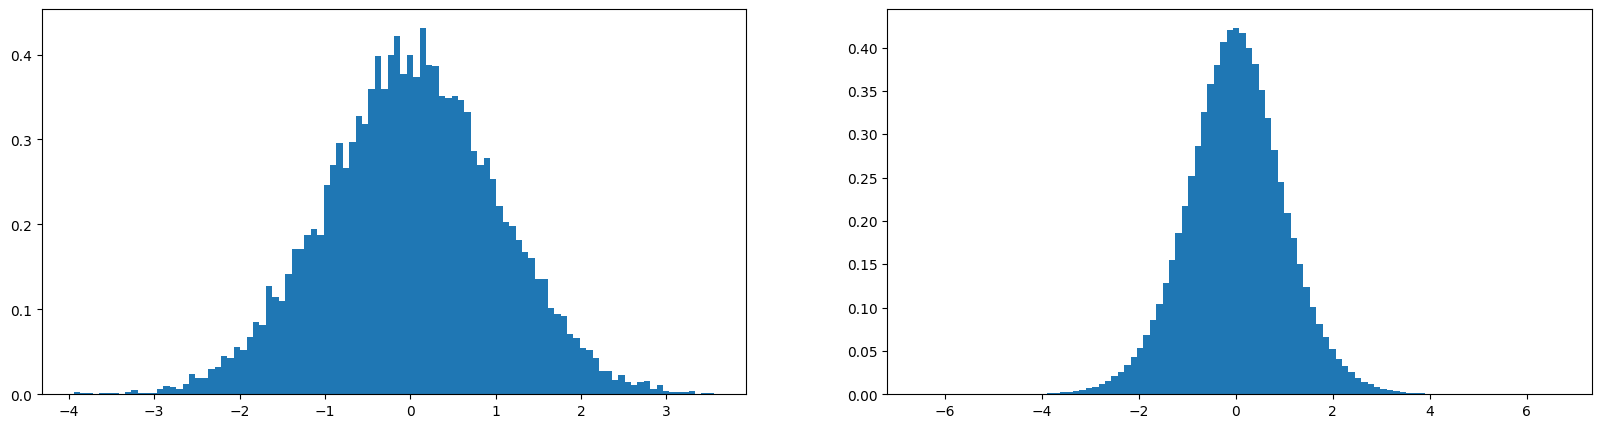

In [160]:
import pandas as pd
import pygwalker as pyg
x = torch.randn(1000, 10)
w = torch.randn(10, 1000) / 10**0.5 # divide by sqrt(d) to keep variance constant

y = x @ w
print(y.size())
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), density=True, bins=100)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), density=True, bins=100)



In [161]:
lri = []
lossi = []
stepi = []

In [162]:
batch_size = 32
lossi = []
max_steps = 200000
for i in tqdm(range(max_steps)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(-1, n_inputs) # concatenate the vectors
    hpreact = embcat @ W1# + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats:
    if i % 10000 == 0:
        print(f'{i} {loss.item():.3f}')

    lossi.append(loss.log10().item())
    stepi.append(i)
    

print(loss.item())


  0%|          | 418/200000 [00:00<01:35, 2088.09it/s]

0 3.282


  5%|▌         | 10365/200000 [00:04<01:24, 2250.49it/s]

10000 2.387


 10%|█         | 20397/200000 [00:08<01:20, 2241.38it/s]

20000 2.017


 15%|█▌        | 30409/200000 [00:13<01:13, 2307.57it/s]

30000 2.640


 20%|██        | 40222/200000 [00:17<01:07, 2369.26it/s]

40000 2.356


 25%|██▌       | 50439/200000 [00:21<01:02, 2381.77it/s]

50000 2.546


 30%|███       | 60251/200000 [00:26<00:58, 2389.37it/s]

60000 2.162


 35%|███▌      | 70304/200000 [00:30<00:54, 2383.42it/s]

70000 1.977


 40%|████      | 80340/200000 [00:34<00:50, 2361.36it/s]

80000 2.024


 45%|████▌     | 90401/200000 [00:38<00:46, 2349.33it/s]

90000 2.001


 50%|█████     | 100261/200000 [00:42<00:41, 2406.57it/s]

100000 2.059


 55%|█████▌    | 110338/200000 [00:47<00:37, 2396.29it/s]

110000 2.074


 60%|██████    | 120368/200000 [00:51<00:33, 2377.82it/s]

120000 1.834


 65%|██████▌   | 130416/200000 [00:55<00:29, 2393.61it/s]

130000 2.211


 70%|███████   | 140254/200000 [00:59<00:24, 2406.19it/s]

140000 2.111


 75%|███████▌  | 150391/200000 [01:03<00:20, 2446.52it/s]

150000 1.736


 80%|████████  | 160463/200000 [01:08<00:16, 2398.10it/s]

160000 2.186


 85%|████████▌ | 170248/200000 [01:12<00:12, 2383.68it/s]

170000 2.417


 90%|█████████ | 180326/200000 [01:16<00:08, 2398.47it/s]

180000 2.488


 95%|█████████▌| 190452/200000 [01:20<00:03, 2390.20it/s]

190000 2.471


100%|██████████| 200000/200000 [01:24<00:00, 2357.07it/s]

1.7001441717147827


torch.Size([32, 200])

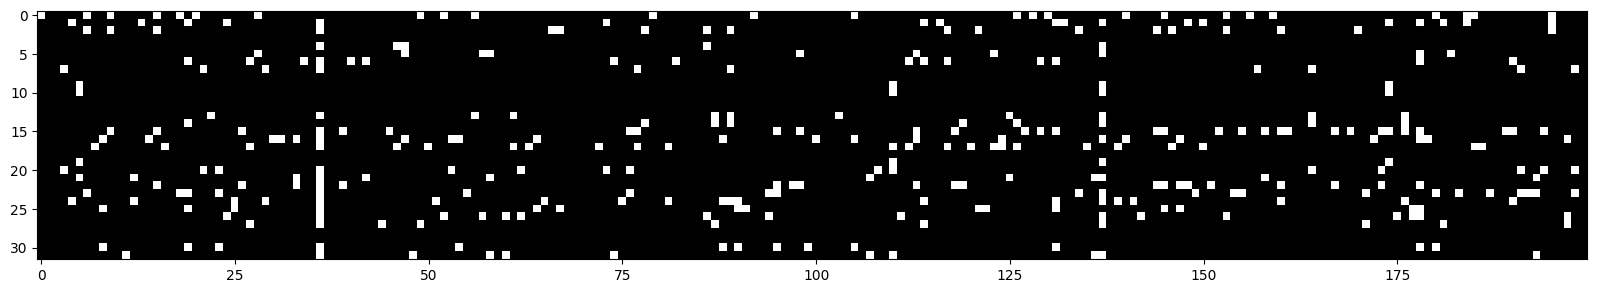

In [163]:
#plt.hist(h.view(-1).tolist(), 50);
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
h.shape

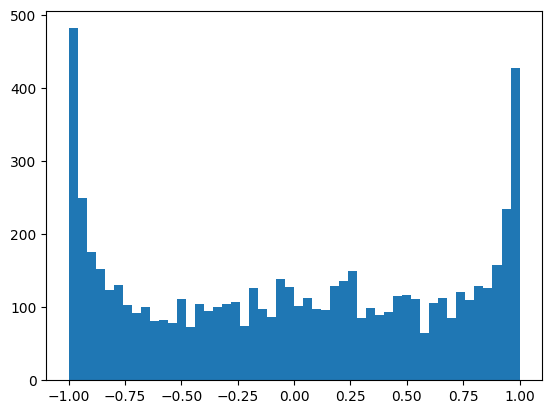

In [164]:
plt.hist(h.view(-1).tolist(), 50);

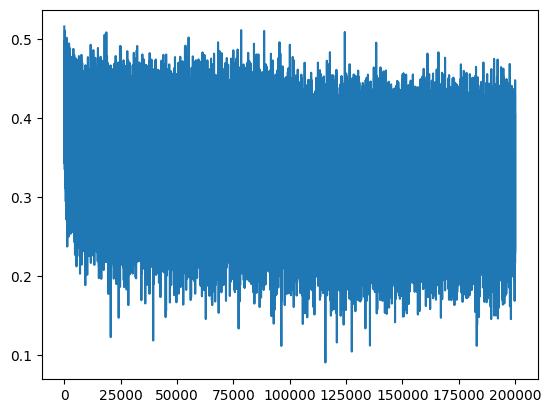

In [165]:
plt.plot(stepi, lossi)

In [166]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(-1, n_inputs)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

split_loss('train')
split_loss('dev')

2.067202091217041
2.1071884632110596


In [170]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[ix] for ix in out))

texzadifglsustinczitth.
stlqimiltangrakfagrnatdh.
stezyah.
jaxsomintsi.
khzirshavuggwoxddrekk.
kyvagsidly.
tibvgrryck.
bstuhlyndervangelsw.
ssof.
blakslanyightranc.
kazdyn.
kyzlestus.
khar.
taybidanshudbshattz.
zyssqeyghnrixmenahrishnn.
marisandricktzedrishmohsobidenzadelyssahmiqkentlyniq.
vebdmidsmeszadtmmigambrek.
keislynslivllangriffynn.
sak.
stza.
